# Desafio Keyrus
# Solução desenvolvida por Danilo Morales Teixeira
# 18/09/2019

importanto as principais bibliotecas para o estudo

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
dataset = pd.read_csv('predictive_maintenance.csv',encoding = "ISO-8859-1")

Exibindo as cinco primeiras linhas

In [32]:
dataset.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


Podemos observar que as colunas data e device não são necessárias para o nosso estudo e serão removidas

In [33]:
dataset = dataset.drop(['date','device'],axis=1)

Verificando se as colunas foram removidas

In [34]:
dataset.head()

,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,0,215630672,56,0,52,6,407438,0,0,7
1,0,61370680,0,3,0,6,403174,0,0,0
2,0,173295968,0,0,0,12,237394,0,0,0
3,0,79694024,0,0,0,6,410186,0,0,0
4,0,135970480,0,0,0,15,313173,0,0,3


Determinando a existencia de NaNs

In [35]:
dataset.isna().sum()

failure       0
attribute1    0
attribute2    0
attribute3    0
attribute4    0
attribute5    0
attribute6    0
attribute7    0
attribute8    0
attribute9    0
dtype: int64

Observa-se que este dataset não possui valores do tipo NaN

In [36]:
dataset['failure_convertido'] = dataset['failure'].map({0 : 'non-failure', 1 : 'Failure'})

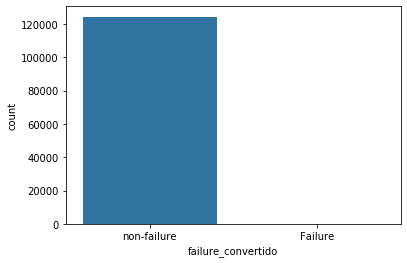

In [37]:
sns.countplot(x='failure_convertido',data=dataset);

In [38]:
sem_falha = len(dataset[dataset['failure'] == 0])
com_falha = len(dataset[dataset['failure'] == 1])

In [39]:
print("Equipamentos sem falha = {}".format(sem_falha))
print("Equipamentos com falha = {}".format(com_falha))

Equipamentos sem falha = 124388
Equipamentos com falha = 106


In [40]:
print('Sem falhas', round(dataset['failure'].value_counts()[0]/len(dataset) * 100,2), '%')
print('Com falhas', round(dataset['failure'].value_counts()[1]/len(dataset) * 100,2), '%')

Sem falhas 99.91 %
Com falhas 0.09 %


Podemos observar que existe um grande desbalanceamento nas quantidade de equipamentos com falha em relação aos sem falha

# Nossos dados estão muitos desbalançados e 99.91% dos casos são de equipamentos sem falha. Se utilizarmos este dataset como base para o nosso estudo, obteremos muitos erros e o nosso modelo irá gerar um overfitting pois assumirá que a maioria das operações não apresentaram falhas

# Antes de procedermos com a técnica de subamostra aleatória, devemos separar o dataset original para testar as hipóteses. Embora estejamos separando o dado enquanto implementamos a SubAmostra ou SobreAmostra aleatória, queremos testar o nosso modelo na combinação de teste original e não numa amostra de teste criado por estas técnicas e testa-las.

Importanto as bibliotecas necessárias para criar estar amostras

In [72]:
from imblearn import under_sampling, over_sampling, combine
from sklearn.decomposition import PCA
from sklearn.metrics import precision_score, roc_auc_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from scipy.stats import spearmanr
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from hyperopt import hp, tpe, Trials, STATUS_OK
from hyperopt import fmin

In [42]:
dataset = dataset.drop(['failure_convertido'],axis=1)
X = dataset.drop(['failure'],axis=1)
Y = dataset['failure']

Random Undersampling

The simplest form of undersampling is to remove random records from the majority class. With imblearn's implementation we can choose to remove samples with or without replacement. The biggest drawback to this form of undersampling is loss of information.

In [43]:
rus = under_sampling.RandomUnderSampler(random_state=0)
resamp_x, resamp_y= rus.fit_resample(X, Y)

In [44]:
pca = PCA(n_components=2)
resamp = pd.DataFrame(np.hstack((np.vstack(resamp_y), resamp_x)))

In [45]:
resamp_0 = resamp[resamp[0] == 0.0]
resamp_1 = resamp[resamp[0] == 1.0]

In [46]:
orig_0 = dataset[dataset.failure == 0]
orig_1 = dataset[dataset.failure == 1]

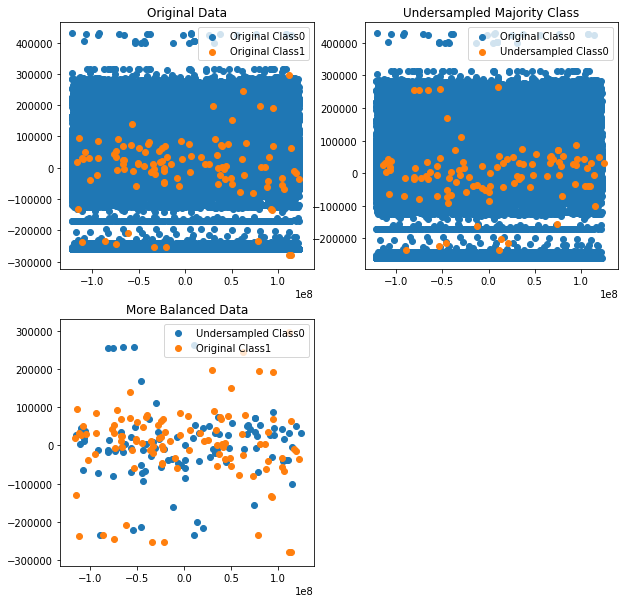

In [48]:
orig_no = pca.fit_transform(orig_0)
orig_yes = pca.fit_transform(orig_1)
resamp_no = pca.fit_transform(resamp_0)
resamp_yes = pca.fit_transform(resamp_1)

ono_x = orig_no[:, 0]
ono_y = orig_no[:, 1]
oyes_x = orig_yes[:, 0]
oyes_y = orig_yes[:, 1]
rno_x = resamp_no[:, 0]
rno_y = resamp_no[:, 1]
ryes_x = resamp_yes[:, 0]
ryes_y = resamp_yes[:, 1]

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs= axs.flatten()
axs[0].set_title('Original Data')
axs[0].scatter(ono_x, ono_y, label='Original Class0')
axs[0].scatter(oyes_x, oyes_y, label='Original Class1')
axs[1].set_title('Undersampled Majority Class')
axs[1].scatter(ono_x, ono_y, label='Original Class0')
axs[1].scatter(rno_x, rno_y, label='Undersampled Class0')
axs[2].set_title('More Balanced Data')
axs[2].scatter(rno_x, rno_y, label='Undersampled Class0')
axs[2].scatter(oyes_x, oyes_y, label='Original Class1')
axs[0].legend()
axs[1].legend()
axs[2].legend()
fig.delaxes(axs[3])
plt.show()

Tomek Links

Tomek links can be used as an under-sampling method or as a data cleaning method. A Tomek link is any place where two samples of different classes are nearest neighbors. When we find a Tomek link we can choose which observatin to delete- in undersampling we remove the majority class.

The difference between the data before and after Tomek links is subtle but clear- Tomek links is a great technique we can use to clear up our boundaries in classificatino problems.

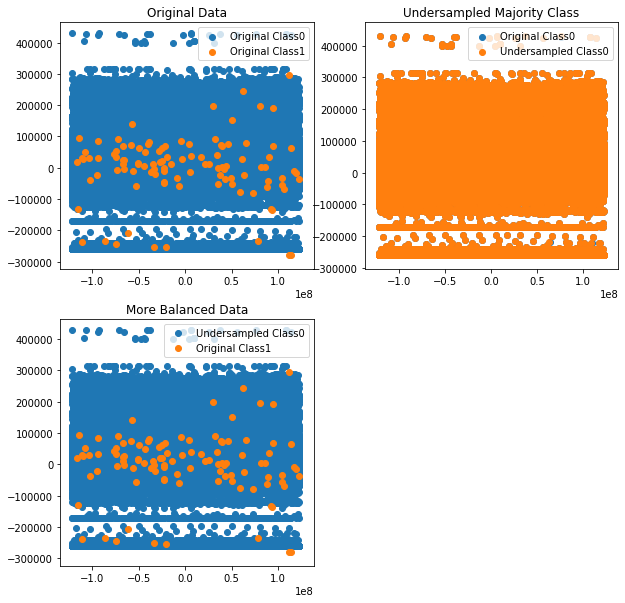

In [51]:
tom = under_sampling.TomekLinks(random_state=0)
resamp_x, resamp_y= tom.fit_resample(X, Y)
# Transform the resampled data into principal components
pca = PCA(n_components=2)
resamp = pd.DataFrame(np.hstack((np.vstack(resamp_y), resamp_x)))

resamp_0 = resamp[resamp[0] == 0.0]
resamp_1 = resamp[resamp[0] == 1.0]
orig_0 = dataset[dataset.failure == 0]
orig_1 = dataset[dataset.failure == 1]

orig_no = pca.fit_transform(orig_0)
orig_yes = pca.fit_transform(orig_1)
resamp_no = pca.fit_transform(resamp_0)
resamp_yes = pca.fit_transform(resamp_1)

ono_x = orig_no[:, 0]
ono_y = orig_no[:, 1]
oyes_x = orig_yes[:, 0]
oyes_y = orig_yes[:, 1]
rno_x = resamp_no[:, 0]
rno_y = resamp_no[:, 1]
ryes_x = resamp_yes[:, 0]
ryes_y = resamp_yes[:, 1]

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs= axs.flatten()
axs[0].set_title('Original Data')
axs[0].scatter(ono_x, ono_y, label='Original Class0')
axs[0].scatter(oyes_x, oyes_y, label='Original Class1')
axs[1].set_title('Undersampled Majority Class')
axs[1].scatter(ono_x, ono_y, label='Original Class0')
axs[1].scatter(rno_x, rno_y, label='Undersampled Class0')
axs[2].set_title('More Balanced Data')
axs[2].scatter(rno_x, rno_y, label='Undersampled Class0')
axs[2].scatter(oyes_x, oyes_y, label='Original Class1')
axs[0].legend()
axs[1].legend()
axs[2].legend()
fig.delaxes(axs[3])
plt.show()

AllKNN

AllKNN is a method also created by the Ivan Tomek that deletes an object if a KNN classifier misclassifies it. In imblearn the default value of k is 3, but we can also pass a value. In the below cell its worth passing different values to n_neighbors. AllKNN tends to delete more datapoints than ENN, especially as the value of k increases.

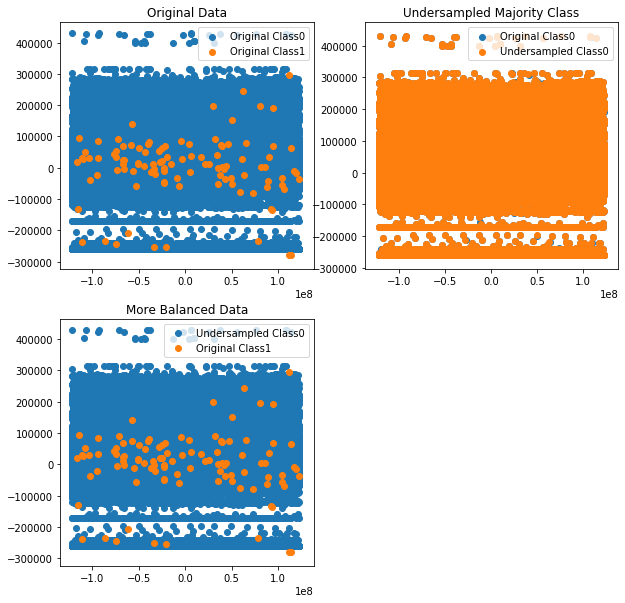

In [54]:
aknn = under_sampling.AllKNN(random_state=0, n_neighbors=10)
resamp_x, resamp_y= aknn.fit_resample(X, Y)
# Transform the resampled data into principal components
pca = PCA(n_components=2)
resamp = pd.DataFrame(np.hstack((np.vstack(resamp_y), resamp_x)))

resamp_0 = resamp[resamp[0] == 0.0]
resamp_1 = resamp[resamp[0] == 1.0]
orig_0 = dataset[dataset.failure == 0]
orig_1 = dataset[dataset.failure == 1]

orig_no = pca.fit_transform(orig_0)
orig_yes = pca.fit_transform(orig_1)
resamp_no = pca.fit_transform(resamp_0)
resamp_yes = pca.fit_transform(resamp_1)

ono_x = orig_no[:, 0]
ono_y = orig_no[:, 1]
oyes_x = orig_yes[:, 0]
oyes_y = orig_yes[:, 1]
rno_x = resamp_no[:, 0]
rno_y = resamp_no[:, 1]
ryes_x = resamp_yes[:, 0]
ryes_y = resamp_yes[:, 1]

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs= axs.flatten()
axs[0].set_title('Original Data')
axs[0].scatter(ono_x, ono_y, label='Original Class0')
axs[0].scatter(oyes_x, oyes_y, label='Original Class1')
axs[1].set_title('Undersampled Majority Class')
axs[1].scatter(ono_x, ono_y, label='Original Class0')
axs[1].scatter(rno_x, rno_y, label='Undersampled Class0')
axs[2].set_title('More Balanced Data')
axs[2].scatter(rno_x, rno_y, label='Undersampled Class0')
axs[2].scatter(oyes_x, oyes_y, label='Original Class1')
axs[0].legend()
axs[1].legend()
axs[2].legend()
fig.delaxes(axs[3])
plt.show()

ENN (Edited Nearest Neighbours)

ENN removes examples whose class label differs from the class of at least half of its k nearest neighbors. The benefit of ENN is that we can remove examples of the majority class while retaining as much information as possible because we are only removing redundant observations.

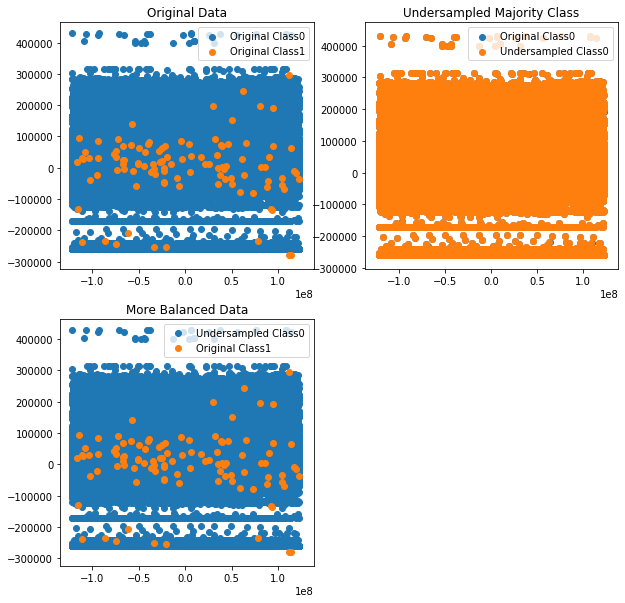

In [55]:
enn = under_sampling.EditedNearestNeighbours(random_state=0, n_neighbors=3)
resamp_x, resamp_y= enn.fit_resample(X, Y)
# Transform the resampled data into principal components
pca = PCA(n_components=2)
resamp = pd.DataFrame(np.hstack((np.vstack(resamp_y), resamp_x)))

resamp_0 = resamp[resamp[0] == 0.0]
resamp_1 = resamp[resamp[0] == 1.0]
orig_0 = dataset[dataset.failure == 0]
orig_1 = dataset[dataset.failure == 1]

orig_no = pca.fit_transform(orig_0)
orig_yes = pca.fit_transform(orig_1)
resamp_no = pca.fit_transform(resamp_0)
resamp_yes = pca.fit_transform(resamp_1)

ono_x = orig_no[:, 0]
ono_y = orig_no[:, 1]
oyes_x = orig_yes[:, 0]
oyes_y = orig_yes[:, 1]
rno_x = resamp_no[:, 0]
rno_y = resamp_no[:, 1]
ryes_x = resamp_yes[:, 0]
ryes_y = resamp_yes[:, 1]

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs= axs.flatten()
axs[0].set_title('Original Data')
axs[0].scatter(ono_x, ono_y, label='Original Class0')
axs[0].scatter(oyes_x, oyes_y, label='Original Class1')
axs[1].set_title('Undersampled Majority Class')
axs[1].scatter(ono_x, ono_y, label='Original Class0')
axs[1].scatter(rno_x, rno_y, label='Undersampled Class0')
axs[2].set_title('More Balanced Data')
axs[2].scatter(rno_x, rno_y, label='Undersampled Class0')
axs[2].scatter(oyes_x, oyes_y, label='Original Class1')
axs[0].legend()
axs[1].legend()
axs[2].legend()
fig.delaxes(axs[3])
plt.show()

In [64]:
batch_size = 10000
xgb_df = dataset.sample(batch_size)
smotomek = combine.SMOTETomek(random_state=0, ratio=0.5)
bal_x, bal_y= smotomek.fit_resample(X, Y)

samp_len = len(bal_y)
xgb_df2 = dataset.sample(batch_size)
xgb_df = pd.concat([xgb_df, xgb_df2])
imb_y = xgb_df['failure'].reset_index(drop=True)
imb_x = xgb_df.drop(columns=['failure'])

In [66]:
def org_results(trials, hyperparams, ratio, model_name):
    fit_idx = -1
    for idx, fit  in enumerate(trials):
        hyp = fit['misc']['vals']
        xgb_hyp = {key:[val] for key, val in hyperparams.items()}
        if hyp == xgb_hyp:
            fit_idx = idx
            break
            
    train_time = str(trials[-1]['refresh_time'] - trials[0]['book_time'])
    acc = round(trials[fit_idx]['result']['accuracy'], 3)
    train_auc = round(trials[fit_idx]['result']['train auc'], 3)
    test_auc = round(trials[fit_idx]['result']['test auc'], 3)
    conf_matrix = trials[fit_idx]['result']['conf matrix']

    results = {
        'model': model_name,
        'ratio': ratio,
        'parameter search time': train_time,
        'accuracy': acc,
        'test auc score': test_auc,
        'training auc score': train_auc,
        'confusion matrix': conf_matrix,
        'parameters': hyperparams
    }
    return results

def data_ratio(y):
    unique, count = np.unique(y, return_counts=True)
    ratio = round(count[0]/count[1], 2)
    return f'{ratio}:1 ({count[0]}/{count[1]})'

In [73]:
def xgb_train(data_x, data_y, md_name):
    ratio = data_ratio(data_y)
    train_x, test_x, train_y, test_y = train_test_split(data_x, data_y, test_size=0.20)
   
    def xgb_objective(space, early_stopping_rounds=50):

        model = XGBClassifier(
            learning_rate = space['learning_rate'], 
            n_estimators = int(space['n_estimators']), 
            max_depth = int(space['max_depth']), 
            min_child_weight = space['m_child_weight'], 
            gamma = space['gamma'], 
            subsample = space['subsample'], 
            colsample_bytree = space['colsample_bytree'],
            objective = 'binary:logistic'
        )

        model.fit(train_x, train_y, 
                  eval_set = [(train_x, train_y), (test_x, test_y)],
                  eval_metric = 'auc',
                  early_stopping_rounds = early_stopping_rounds,
                  verbose = False)

        predictions = model.predict(test_x)
        test_preds = model.predict_proba(test_x)[:,1]
        train_preds = model.predict_proba(train_x)[:,1]

        xgb_booster = model.get_booster()
        train_auc = roc_auc_score(train_y, train_preds)
        test_auc = roc_auc_score(test_y, test_preds)
        accuracy = accuracy_score(test_y, predictions) 
        conf_matrix = confusion_matrix(test_y, predictions)

        return {'status': STATUS_OK, 'loss': 1-test_auc, 'accuracy': accuracy,
                'test auc': test_auc, 'train auc': train_auc, 'conf matrix': conf_matrix
               }

    space = {
        'n_estimators': hp.quniform('n_estimators', 50, 1000, 25),
        'max_depth': hp.quniform('max_depth', 1, 12, 1),
        'm_child_weight': hp.quniform('m_child_weight', 1, 6, 1),
        'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
        'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
        'learning_rate': hp.loguniform('learning_rate', np.log(.001), np.log(.3)),
        'colsample_bytree': hp.quniform('colsample_bytree', .5, 1, .1)
    }

    trials = Trials()
    xgb_hyperparams = fmin(fn = xgb_objective, 
                     max_evals = 25, 
                     trials = trials,
                     algo = tpe.suggest,
                     space = space
                     )
    
    results = org_results(trials.trials, xgb_hyperparams, ratio, md_name)
    return results

bal_results = xgb_train(bal_x, bal_y, 'Balanced Data')
imb_results = xgb_train(imb_x, imb_y, 'Imbalanced Data')

100%|██████████| 25/25 [00:25<00:00,  1.58s/it, best loss: 0.002938969484742482]


In [74]:
bal_confusion = bal_results.pop('confusion matrix')
imb_confusion = imb_results.pop('confusion matrix')

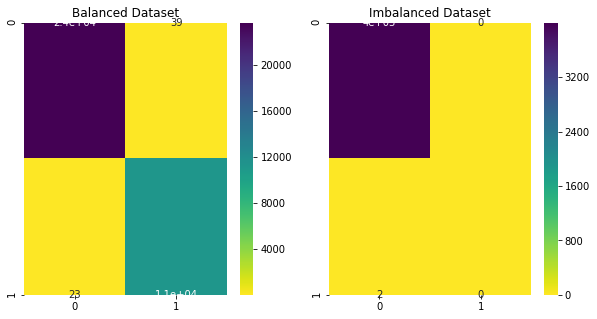

,model,ratio,parameter search time,accuracy,test auc score,training auc score,parameters
0,Balanced Data,2.11:1 (118476/56282),0:37:46.189000,0.998,1.000,1.000,"{'colsample_bytree': 0.6000000000000001, 'gamm..."
1,Imbalanced Data,1332.33:1 (19985/15),0:00:25.101000,1.000,0.997,0.865,"{'colsample_bytree': 0.8, 'gamma': 0.850000000..."


In [75]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.heatmap(bal_confusion, annot=True, cmap= 'viridis_r', ax=ax[0])
sns.heatmap(imb_confusion, annot=True, cmap= 'viridis_r', ax=ax[1])
ax[0].set_title('Balanced Dataset')
ax[1].set_title('Imbalanced Dataset')
plt.show()
final_results = pd.DataFrame([bal_results, imb_results])
display(final_results) 

Observamos que balanceando os dados a precisão fica de acordo com o esperado